# Chapter 16

## Technical Requirements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


plt.style.use('grayscale')

In [3]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [14, 4]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [4]:
import statsmodels as sm
from statsmodels.tools.eval_measures import rmse, meanabs as mae


print(f'''
statsmodels -> {sm.__version__}
''')



statsmodels -> 0.14.5



In [5]:
folder = Path('../../datasets/Ch16/')
file = folder.joinpath('AEP_hourly.csv')

df = pd.read_csv(file, index_col='Datetime', parse_dates=True)

In [6]:
df.sort_index(inplace=True)
df = df.resample('h').last()
df.columns = ['y']
df.ffill(inplace=True)

print(f"Final dataset shape: {df.shape}")
print(f"Data frequency: {df.index.freq}")
print(f"Any missing values: {df.isnull().any().any()}")

Final dataset shape: (121296, 1)
Data frequency: <Hour>
Any missing values: False


<Axes: title={'center': 'American Power Electric Energy Consumption in Megawatts (MW)'}, xlabel='Datetime'>

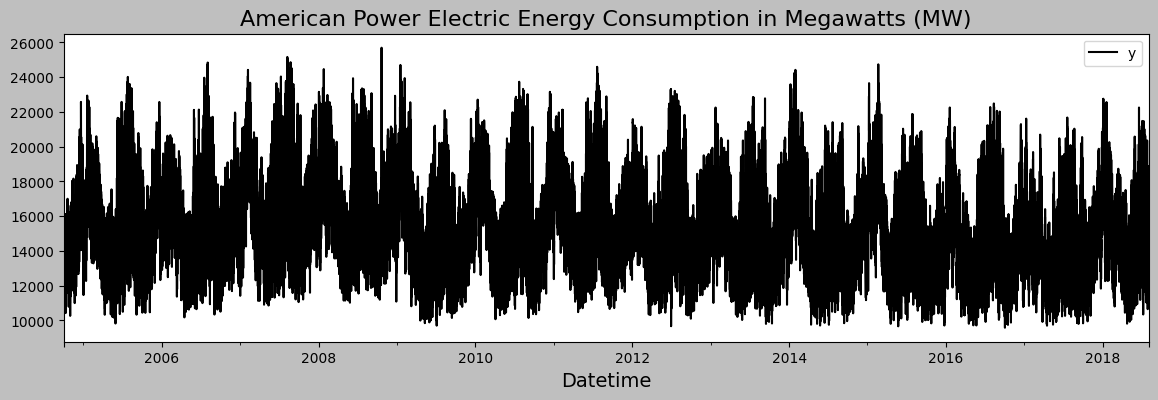

In [7]:
df.plot(title='American Power Electric Energy Consumption in Megawatts (MW)')

# Prediction Intervals with Statsmodels

In [7]:
day = 24
week = day*7
year = day*365
print(f'''
day = {day} hours
week = {week} hours
year = {year} hours
''')


day = 24 hours
week = 168 hours
year = 8760 hours



In [8]:
df.head()

,y
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [9]:
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.statespace.sarimax import SARIMAX


fourier_daily  = Fourier(period=day,    order=4) 
fourier_weekly = Fourier(period=week,   order=6) 
fourier_annual = Fourier(period=year, order=8)  


In [10]:
fourier_daily

Fourier(period=24.0, order=4) at 0x15f78c6e0

In [11]:
# Concatenate their in_sample() outputs
idx = df.index 
X_list = [
    fourier_daily.in_sample(idx),
    fourier_weekly.in_sample(idx),
    fourier_annual.in_sample(idx),
]

X = pd.concat(X_list, axis=1)
print(X.columns)

Index(['sin(1,24)', 'cos(1,24)', 'sin(2,24)', 'cos(2,24)', 'sin(3,24)',
       'cos(3,24)', 'sin(4,24)', 'cos(4,24)', 'sin(1,168)', 'cos(1,168)',
       'sin(2,168)', 'cos(2,168)', 'sin(3,168)', 'cos(3,168)', 'sin(4,168)',
       'cos(4,168)', 'sin(5,168)', 'cos(5,168)', 'sin(6,168)', 'cos(6,168)',
       'sin(1,8760)', 'cos(1,8760)', 'sin(2,8760)', 'cos(2,8760)',
       'sin(3,8760)', 'cos(3,8760)', 'sin(4,8760)', 'cos(4,8760)',
       'sin(5,8760)', 'cos(5,8760)', 'sin(6,8760)', 'cos(6,8760)',
       'sin(7,8760)', 'cos(7,8760)', 'sin(8,8760)', 'cos(8,8760)'],
      dtype='object')


In [12]:
X.shape

(121296, 36)

In [13]:
# for i in X.columns:
#     X[i].tail(168).plot(title=i)
#     plt.show()

In [14]:
train = df.iloc[:-week]
test = df.iloc[-week:]
exog_train = X.iloc[:-week]
exog_test = X.iloc[-week:]

In [15]:
mod = SARIMAX(
    train['y'], 
    exog=exog_train,
    order=(1, 0, 1)
)
res = mod.fit(disp=False)

In [16]:
res

In [17]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               121128
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -857230.506
Date:                Sun, 24 Aug 2025   AIC                        1714539.012
Time:                        00:03:59   BIC                        1714917.492
Sample:                    10-01-2004   HQIC                       1714652.891
                         - 07-27-2018                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sin(1,24)   -1183.8134      8.889   -133.182      0.000   -1201.235   -1166.392
cos(1,24)   -1200.4913      7.539   -159.238      0.000   -1215.267   -1185.715
sin(2,24)    -734.6357      3.748   -196.018    

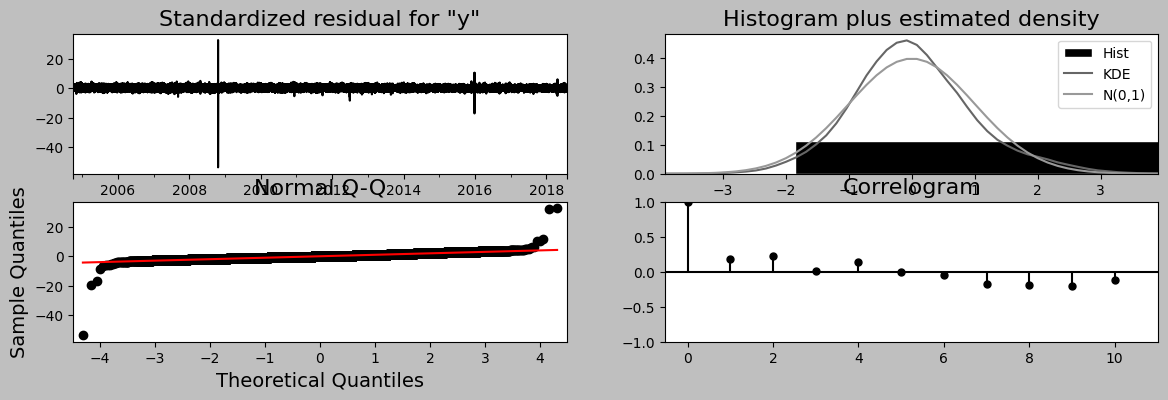

In [18]:
res.plot_diagnostics()
plt.show()

In [19]:
fc = res.get_forecast(steps=len(test), 
                      exog=exog_test)

In [20]:
fc

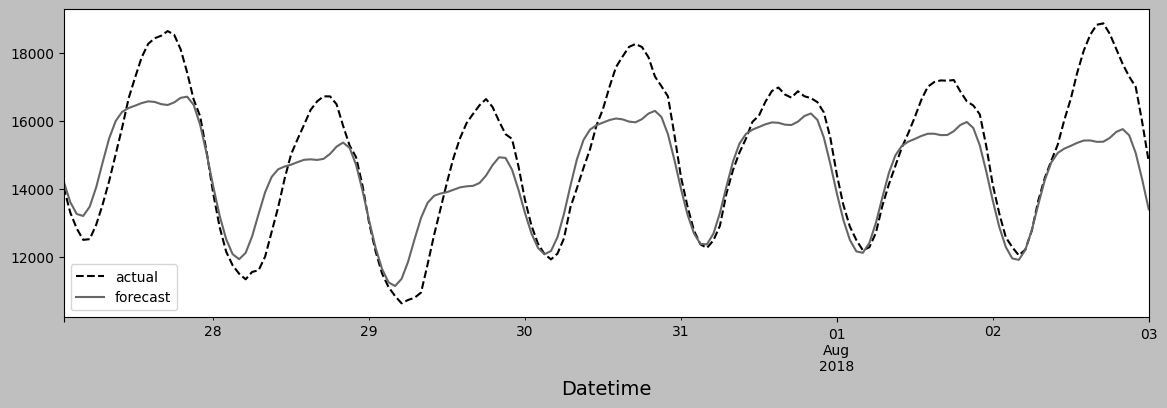

In [21]:
test.plot(style='--')
fc.predicted_mean.plot()
plt.legend(['actual', 'forecast'])
plt.show()

In [22]:
yhat = fc.predicted_mean

sarimax_mae = mae(test['y'], yhat)
sarimax_rmse = rmse(test['y'], yhat)
print(f'SARIMAX MAE: {sarimax_mae}')
print(f'SARIMAX RMSE: {sarimax_rmse}')

SARIMAX MAE: 905.377821530133
SARIMAX RMSE: 1180.8093838302636


In [23]:
fc.summary_frame()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-07-27 01:00:00,14223.695209,286.563181,13662.041695,14785.348724
2018-07-27 02:00:00,13623.760321,543.911937,12557.712513,14689.808128
2018-07-27 03:00:00,13271.119250,713.682777,11872.326710,14669.911789
2018-07-27 04:00:00,13214.167316,850.074946,11548.051038,14880.283594
2018-07-27 05:00:00,13486.348493,967.312432,11590.450965,15382.246021
...,...,...,...,...
2018-08-02 20:00:00,15763.502823,5672.921594,4644.780812,26882.224834
2018-08-02 21:00:00,15579.953561,5688.839453,4430.033119,26729.874002
2018-08-02 22:00:00,15058.786418,5704.696666,3877.786410,26239.786427
2018-08-02 23:00:00,14278.261823,5720.493755,3066.300090,25490.223557


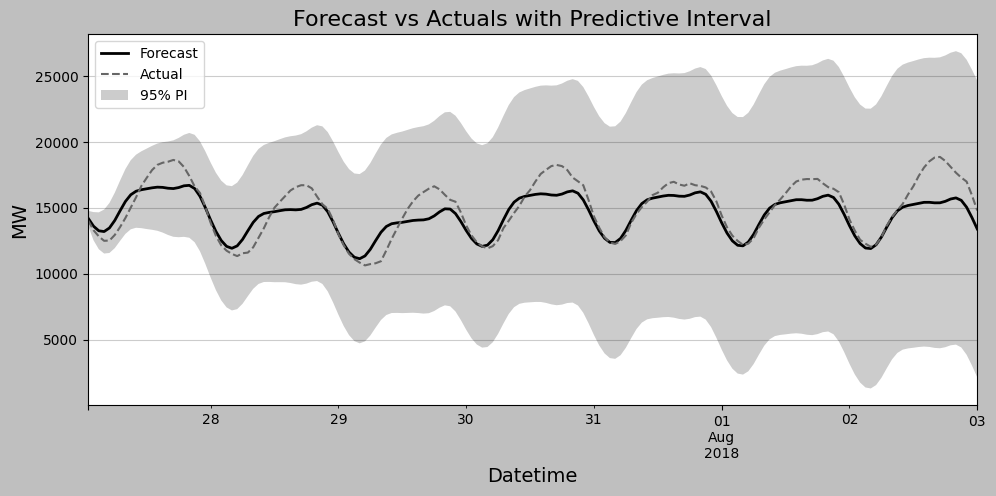

In [24]:
import matplotlib.pyplot as plt

# Extract forecast pieces
yhat = fc.predicted_mean
pi   = fc.conf_int(alpha=0.05)

lower_col = pi['lower y']
upper_col = pi['upper y']

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Forecast mean
yhat.plot(ax=ax, lw=2, label='Forecast')

# Actuals (test)
test ['y'].plot(ax=ax, style='--', lw=1.5, label='Actual')

# Prediction band
ax.fill_between(
    pi.index, 
    lower_col, 
    upper_col,
    alpha=0.2, # prediction band transparency
    label='95% PI'
)

ax.set_title('Forecast vs Actuals with Predictive Interval')
ax.set_xlabel('Datetime')
ax.set_ylabel('MW')
ax.legend()
ax.grid(True, axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


In [25]:
# example of confidence intervals (CI)
res.conf_int()

,0,1
"sin(1,24)",-1201.234901,-1166.391836
"cos(1,24)",-1215.267455,-1185.715169
"sin(2,24)",-741.981240,-727.290110
"cos(2,24)",-280.535296,-263.055203
"sin(3,24)",-96.987100,-86.868800
"cos(3,24)",-39.366196,-29.545981
"sin(4,24)",82.622157,89.949219
"cos(4,24)",-13.783338,-6.830208
"sin(1,168)",-962.489560,-764.129463
"cos(1,168)",109.718840,318.272094


## There's more

In [26]:
# Prediction Intervals in StatsForecast

In [27]:
from statsforecast import StatsForecast

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
import statsforecast
statsforecast.__version__

'2.0.2'

In [29]:
sf_df = df.reset_index().copy()
sf_df['unique_id'] = 'AEP_hourly'
sf_df = sf_df.rename(columns={'Datetime': 'ds'})
sf_df


,ds,y,unique_id
0,2004-10-01 01:00:00,12379.0,AEP_hourly
1,2004-10-01 02:00:00,11935.0,AEP_hourly
2,2004-10-01 03:00:00,11692.0,AEP_hourly
3,2004-10-01 04:00:00,11597.0,AEP_hourly
4,2004-10-01 05:00:00,11681.0,AEP_hourly
...,...,...,...
121291,2018-08-02 20:00:00,17673.0,AEP_hourly
121292,2018-08-02 21:00:00,17303.0,AEP_hourly
121293,2018-08-02 22:00:00,17001.0,AEP_hourly
121294,2018-08-02 23:00:00,15964.0,AEP_hourly


In [30]:
day = 24
week = day*7

sf_train = sf_df.iloc[:-week]
sf_test = sf_df.iloc[-week:]

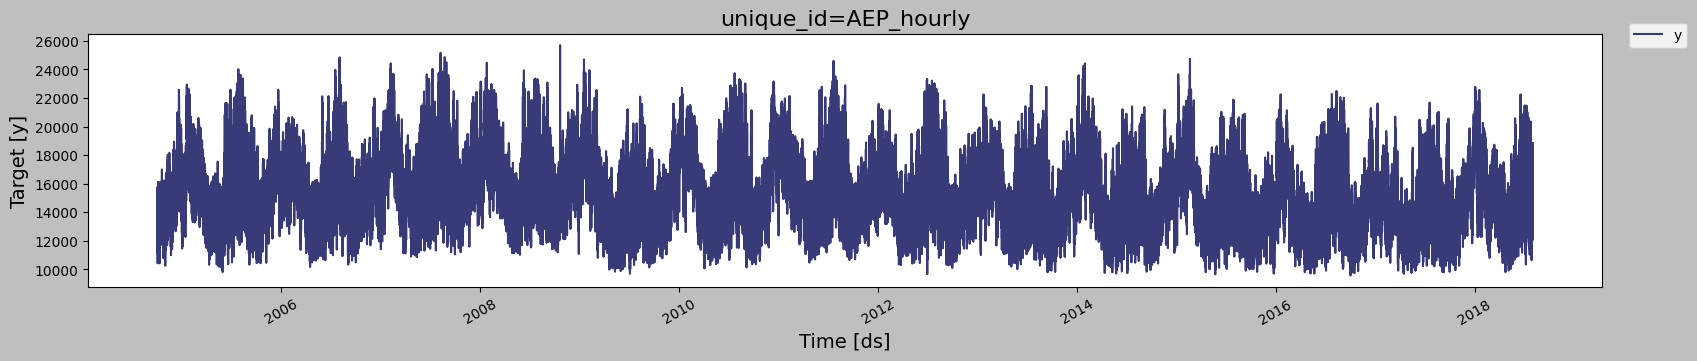

In [31]:
StatsForecast.plot(sf_train, sf_test)

In [32]:
from statsforecast.models import MSTL, AutoARIMA
mstl = MSTL(
    season_length=[day, week], 
    trend_forecaster=AutoARIMA() 
)

sf = StatsForecast(
    models=[mstl],
    freq='H',
    n_jobs=-1
)

In [33]:
sf.fit(sf_train)

StatsForecast(models=[MSTL])

In [34]:
levels = [80, 90, 95]
sf_forecast = sf.predict(h=168, level=levels)
sf_forecast.head()

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


,unique_id,ds,MSTL,MSTL-lo-95,MSTL-lo-90,MSTL-lo-80,MSTL-hi-80,MSTL-hi-90,MSTL-hi-95
0,AEP_hourly,2018-07-27 01:00:00,14075.815222,13870.632277,13903.620266,13941.653305,14209.977138,14248.010177,14280.998166
1,AEP_hourly,2018-07-27 02:00:00,13356.375400,13012.647087,13067.909506,13131.623536,13581.127263,13644.841293,13700.103713
2,AEP_hourly,2018-07-27 03:00:00,12851.335911,12364.002414,12442.352748,12532.685665,13169.986157,13260.319074,13338.669408
3,AEP_hourly,2018-07-27 04:00:00,12644.714237,12021.343109,12121.564695,12237.113765,13052.314709,13167.863779,13268.085365
4,AEP_hourly,2018-07-27 05:00:00,12711.650625,11962.328521,12082.799692,12221.695236,13201.606013,13340.501557,13460.972728


In [35]:
sf.fitted_

array([[MSTL]], dtype=object)

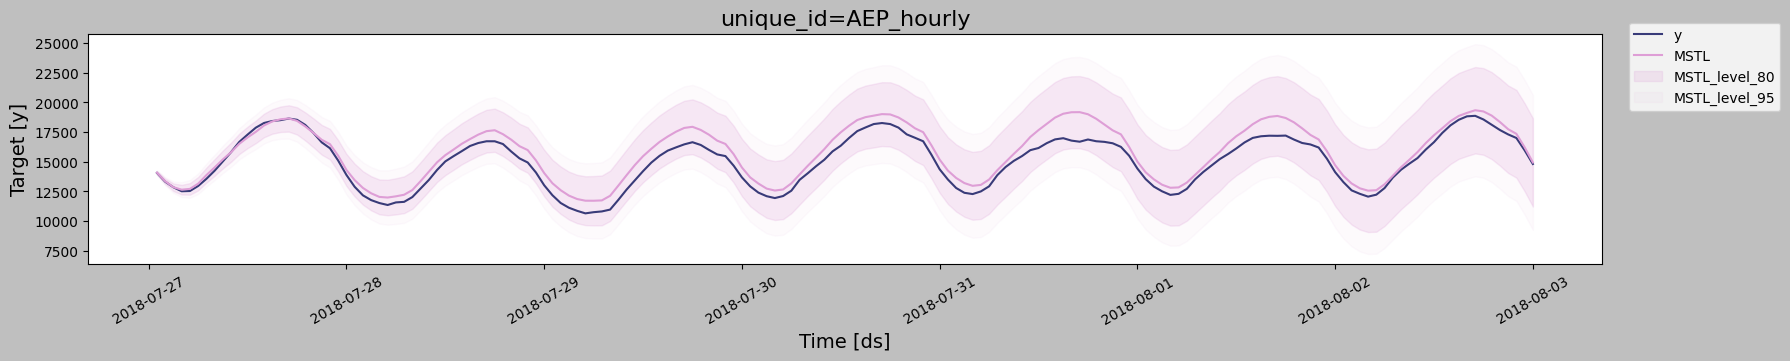

In [36]:
sf.plot(sf_test, sf_forecast, models=['MSTL'], level=[80,95])

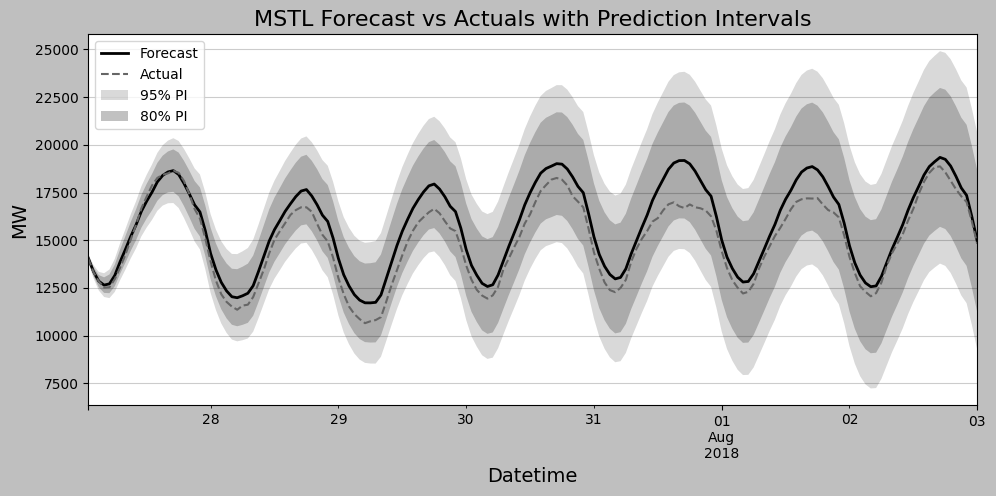

In [37]:
import matplotlib.pyplot as plt

sf_forecast.set_index('ds', inplace=True)

# Extract forecast 
sf_yhat = sf_forecast['MSTL']

lower_95 = sf_forecast['MSTL-lo-95']
upper_95 = sf_forecast['MSTL-hi-95']
lower_80 = sf_forecast['MSTL-lo-80']
upper_80 = sf_forecast['MSTL-hi-80']

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

# Forecast mean
sf_yhat.plot(ax=ax, lw=2, label='Forecast')

# Actuals (test)
sf_test.set_index('ds')['y'].plot(ax=ax, style='--', lw=1.5, label='Actual')

# Plot the 95% prediction interval
ax.fill_between(
    sf_forecast.index, 
    lower_95, 
    upper_95,
    alpha=0.15, # prediction band transparency
    label='95% PI'
)
# Plot the 80% prediction interval
ax.fill_between(
    sf_forecast.index, 
    lower_80, 
    upper_80,
    alpha=0.4, # prediction band transparency
    label='80% PI'
)

ax.set_title('MSTL Forecast vs Actuals with Prediction Intervals')
ax.set_xlabel('Datetime')
ax.set_ylabel('MW')
ax.legend()
ax.grid(True, axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

In [38]:
mstl_mae = mae(sf_test['y'], sf_yhat)
mstl_rmse = rmse(sf_test['y'], sf_yhat)
sarimax_mae = mae(test['y'], yhat)
sarimax_rmse = rmse(test['y'], yhat)

print(f'MSTL MAE: {mstl_mae}')
print(f'MSTL RMSE: {mstl_rmse}')

print(f'SARIMAX MAE: {sarimax_mae}')
print(f'SARIMAX RMSE: {sarimax_rmse}')

MSTL MAE: 756.7793753275537
MSTL RMSE: 886.4183741972955
SARIMAX MAE: 905.377821530133
SARIMAX RMSE: 1180.8093838302636


# Probabilistic Forecasting with Darts

In [39]:
# !uv pip install darts

In [39]:
from darts.models import NHiTSModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse, mae, mql
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import torch

In [40]:
df.head()

,y
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [41]:
darts_df = df.reset_index().copy()

ts = TimeSeries.from_dataframe(darts_df, 
                               time_col='Datetime', 
                               value_cols='y', 
                               freq='h')
ts = ts.astype(np.float32)

day = 24
week = day*7

n_total = len(ts)
n_test = day*2 
n_val = week*2

# Calculate split indices
test_start = n_total - n_test
val_start = test_start - n_val
        
# Create splits maintaining temporal order
d_train = ts[:val_start]
d_val = ts[val_start:test_start]
d_test = ts[test_start:]

print(f"""
train_np : {len(d_train)}
val_np : {len(d_val)}
test_np: {len(d_test)}
""")


train_np : 120912
val_np : 336
test_np: 48



In [42]:
d_scaler = Scaler(StandardScaler())

d_train_scaled = d_scaler.fit_transform(d_train)
d_val_scaled = d_scaler.transform(d_val)
d_test_scaled = d_scaler.transform(d_test)

### Point Forecast

In [43]:
%%time

PATIENCE=10 # lowered the EarlyStopping threshold 
early_stopper = EarlyStopping(
    monitor="val_loss", 
    patience=PATIENCE,  
    min_delta=0.001,    
    mode='min',         
    verbose=True)

trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, 
    "accelerator":"auto"}

lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        "verbose": True
    }

nhits_point_model = NHiTSModel(
    input_chunk_length=day*5, # 120 hours in 
    output_chunk_length=day*2, # 48 hours out 
    n_epochs=100, # modified
    num_blocks=1, 
    num_stacks=2, # modified (lowered)
    num_layers=1, # modified (lowered)
    pooling_kernel_sizes=None,
    n_freq_downsample=None, 
    batch_size=168, # modified (increased from 32)
    optimizer_kwargs={"lr": 0.001},
    model_name="AEP_hourly_pf",
    random_state=42,
    force_reset=True,
    save_checkpoints=True,
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs
)


# Fit the model with transformed target data and covariates
nhits_point_model.fit(
    series=d_train_scaled,
    val_series=d_val_scaled,
    verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 153 K  | train
-------------------------------------------------------------
91.7 K    Trainable params
61.6 K    Non-trainable params
153 K     Total params
0.613 

Epoch 0: 100%|██████████| 719/719 [00:10<00:00, 71.73it/s, train_loss=0.189, val_loss=0.0981]

Metric val_loss improved. New best score: 0.098


Epoch 1: 100%|██████████| 719/719 [00:07<00:00, 90.12it/s, train_loss=0.225, val_loss=0.0878]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.088


Epoch 3: 100%|██████████| 719/719 [00:07<00:00, 90.51it/s, train_loss=0.202, val_loss=0.0753]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.075


Epoch 13: 100%|██████████| 719/719 [00:08<00:00, 88.59it/s, train_loss=0.137, val_loss=0.0765] 

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.075. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 719/719 [00:08<00:00, 88.45it/s, train_loss=0.137, val_loss=0.0765]
CPU times: user 1min 48s, sys: 20.9 s, total: 2min 9s
Wall time: 2min


NHiTSModel(output_chunk_shift=0, num_stacks=2, num_blocks=1, num_layers=1, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=120, output_chunk_length=48, n_epochs=100, batch_size=168, optimizer_kwargs={'lr': 0.001}, model_name=AEP_hourly_pf, random_state=42, force_reset=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 3, 'min_lr': 1e-06, 'verbose': True}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x32a937380>], 'enable_progress_bar': True, 'accelerator': 'auto'})

In [44]:
d_train_val_sc = d_train_scaled.append(d_val_scaled)

nhits_forecast_sc = nhits_point_model.predict(
    n=len(d_test),
    series=d_train_val_sc)
# inverse transformation to get the forecast back to original scale
nhits_forecast_inv = d_scaler.inverse_transform(nhits_forecast_sc)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.98it/s]


In [45]:
rmse_val = rmse(d_test, nhits_forecast_inv)
mae_val = mae(d_test, nhits_forecast_inv)
print(f"Darts Test Set MAE:  {mae_val:.4f}")
print(f"Darts Test Set RMSE: {rmse_val:.4f}")

Darts Test Set MAE:  451.6748
Darts Test Set RMSE: 525.1127


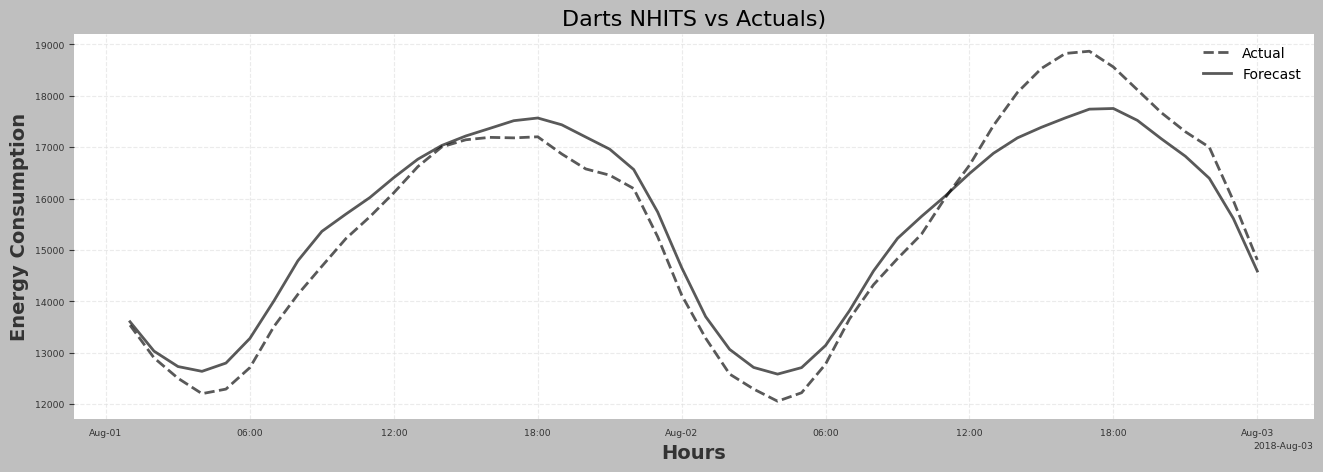

In [46]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65)
nhits_forecast_inv.plot(label='Forecast', color='k', linestyle='-', alpha=0.65)
plt.title('Darts NHITS vs Actuals)')
plt.xlabel('Hours')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### with MonteCarlo Dropout 

In [47]:
d_train_val_sc = d_train_scaled.append(d_val_scaled)

nhits_forecast_mc = nhits_point_model.predict(
    n=len(d_test),
    series=d_train_val_sc,
    num_samples=200,
    mc_dropout=True
    )

nhits_forecast_mc_inv = d_scaler.inverse_transform(nhits_forecast_mc)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


In [48]:
def plot_darts_forecast(actual_series, forecast_series, title):
    """
    Plots the actual time series against a Darts probabilistic forecast.
    
    Args:
        actual_series (darts.TimeSeries): The ground truth series (e.g., d_test).
        forecast_series (darts.TimeSeries): The probabilistic forecast from a Darts model.
        title (str): The title for the plot.
    """
    plt.figure(figsize=(16, 5))
    
    # Plot the actuals
    actual_series.plot(label='Actual', linestyle='--', alpha=0.65)
    
    # Plot the probabilistic forecast with prediction intervals
    forecast_series.plot(
        label='Forecast',
        color='k',
        linestyle='-',
        alpha=0.25,
        low_quantile=0.05,
        high_quantile=0.95,
        central_quantile=0.5 # This plots the median
    )
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

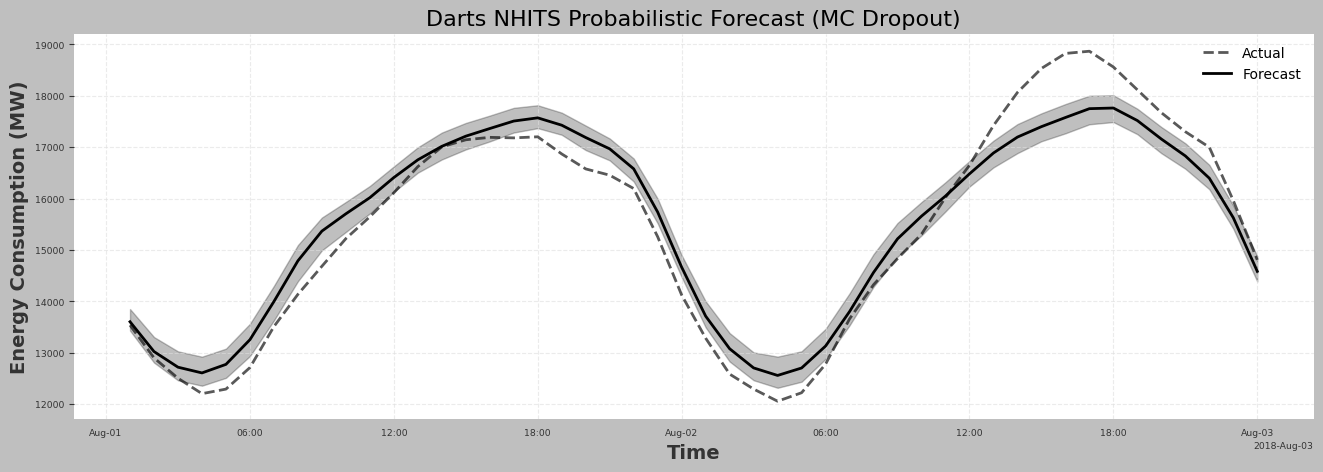

In [49]:
plot_darts_forecast(
    d_test, 
    nhits_forecast_mc_inv, 
    'Darts NHITS Probabilistic Forecast (MC Dropout)'
)

In [50]:
# Calculate the loss for the lower bound (5th percentile)
loss_p05 =mql(d_test, nhits_forecast_mc_inv, q=0.05)

# Calculate the loss for the median (50th percentile)
# This value will be identical to your MAE score
loss_p50 = mql(d_test, nhits_forecast_mc_inv, q=0.50)

# Calculate the loss for the upper bound (95th percentile)
loss_p95 = mql(d_test, nhits_forecast_mc_inv, q=0.95)

print(f"MC Dropout Average Quantile Loss at 5th percentile:  {loss_p05:.4f}")
print(f"MC Dropout Average Quantile Loss at 50th percentile (MAE): {loss_p50:.4f}")
print(f"MC Dropout Average Quantile Loss at 95th percentile: {loss_p95:.4f}")

MC Dropout Average Quantile Loss at 5th percentile:  217.1567
MC Dropout Average Quantile Loss at 50th percentile (MAE): 445.7053
MC Dropout Average Quantile Loss at 95th percentile: 264.8800


### With QuantileRegression Likelihood Parameter

In [51]:
%%time

PATIENCE=10
early_stopper = EarlyStopping(
    monitor="val_loss", 
    patience=PATIENCE,  
    min_delta=0.001,    
    mode='min',         
    verbose=True)

trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, 
    "accelerator":"auto"}

lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        "verbose": True
    }

nhits_d_model_qr = NHiTSModel(
    input_chunk_length=day*5, # 120 hours in 
    output_chunk_length=day*2, # 48 hours out 
    n_epochs=100, # modified
    num_blocks=1, 
    num_stacks=2, # modified (lowered)
    num_layers=1, # modified (lowered)
    pooling_kernel_sizes=None,
    n_freq_downsample=None, 
    batch_size=168, # modified (increased from 32)
    optimizer_kwargs={"lr": 0.001},
    model_name="AEP_hourly_qr",
    random_state=42,
    force_reset=True,
    save_checkpoints=True,
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs,
    likelihood=QuantileRegression([0.05, 0.5, 0.95])
)


# Fit the model with transformed target data and covariates
nhits_d_model_qr.fit(
    series=d_train_scaled,
    val_series=d_val_scaled,
    verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 204 K  | train
-------------------------------------------------------------
143 K     Trainable params
61.6 K    Non-trainable params
204 K     Total params
0.818 

Epoch 0: 100%|██████████| 719/719 [00:10<00:00, 69.52it/s, train_loss=0.229, val_loss=0.192]

Metric val_loss improved. New best score: 0.192


Epoch 1: 100%|██████████| 719/719 [00:09<00:00, 76.23it/s, train_loss=0.242, val_loss=0.167]

Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.167


Epoch 7: 100%|██████████| 719/719 [00:09<00:00, 75.68it/s, train_loss=0.212, val_loss=0.165]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.165


Epoch 15: 100%|██████████| 719/719 [00:09<00:00, 74.41it/s, train_loss=0.192, val_loss=0.163]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.163


Epoch 25: 100%|██████████| 719/719 [00:09<00:00, 72.90it/s, train_loss=0.202, val_loss=0.166]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.163. Signaling Trainer to stop.


Epoch 25: 100%|██████████| 719/719 [00:09<00:00, 72.79it/s, train_loss=0.202, val_loss=0.166]
CPU times: user 3min 53s, sys: 48.4 s, total: 4min 42s
Wall time: 4min 11s


NHiTSModel(output_chunk_shift=0, num_stacks=2, num_blocks=1, num_layers=1, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=120, output_chunk_length=48, n_epochs=100, batch_size=168, optimizer_kwargs={'lr': 0.001}, model_name=AEP_hourly_qr, random_state=42, force_reset=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 3, 'min_lr': 1e-06, 'verbose': True}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x35486d280>], 'enable_progress_bar': True, 'accelerator': 'auto'}, likelihood=QuantileRegression(quantiles=[0.05, 0.5, 0.95], prior_strength=1.0))

In [52]:
d_train_val_sc = d_train_scaled.append(d_val_scaled)

nhits_forecast_qr = nhits_d_model_qr.predict(
    n=len(d_test),
    series=d_train_val_sc,
    num_samples=200
    )

nhits_forecast_qr_inv = d_scaler.inverse_transform(nhits_forecast_qr)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.56it/s]


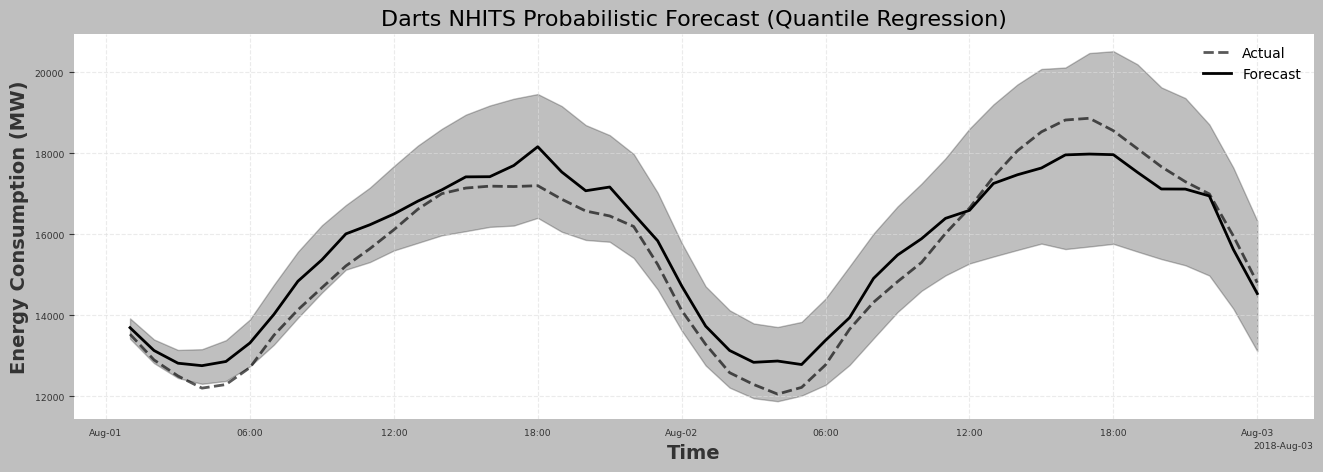

In [53]:
plot_darts_forecast(
    d_test, 
    nhits_forecast_qr_inv, 
    'Darts NHITS Probabilistic Forecast (Quantile Regression)'
)

In [54]:
loss_p05 = mql(d_test, nhits_forecast_qr_inv, q=0.05)
loss_p50 = mql(d_test, nhits_forecast_qr_inv, q=0.50)
loss_p95 = mql(d_test, nhits_forecast_qr_inv, q=0.95)

print(f"QuantileRegression Average Quantile Loss at 5th percentile:  {loss_p05:.4f}")
print(f"QuantileRegression Average Quantile Loss at 50th percentile (MAE): {loss_p50:.4f}")
print(f"QuantileRegression Average Quantile Loss at 95th percentile: {loss_p95:.4f}")

QuantileRegression Average Quantile Loss at 5th percentile:  108.7247
QuantileRegression Average Quantile Loss at 50th percentile (MAE): 496.2605
QuantileRegression Average Quantile Loss at 95th percentile: 162.0029


In [ ]:
y_true_series = d_test
y_pred_p05_series = nhits_forecast_qr_inv.quantile(0.05)
y_pred_p95_series = nhits_forecast_qr_inv.quantile(0.95)

# Calculate the empirical coverage for the 90% interval
# pandas automatically aligns the series by their index
coverage_90 = ((y_true_series >= y_pred_p05_series) & (y_true_series <= y_pred_p95_series)).mean()
print(f"Empirical coverage: {coverage_90:.3f}")

0.9375

### Combinined MonteCarlo Dropout with QuantileRegression Likelihood

In [73]:
d_train_val_sc = d_train_scaled.append(d_val_scaled)

nhits_forecast_qr_mc = nhits_d_model_qr.predict(
    n=len(d_test),
    series=d_train_val_sc,
    num_samples=200,
    mc_dropout=True
    )

nhits_forecast_qr_mc_inv = d_scaler.inverse_transform(nhits_forecast_qr_mc)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


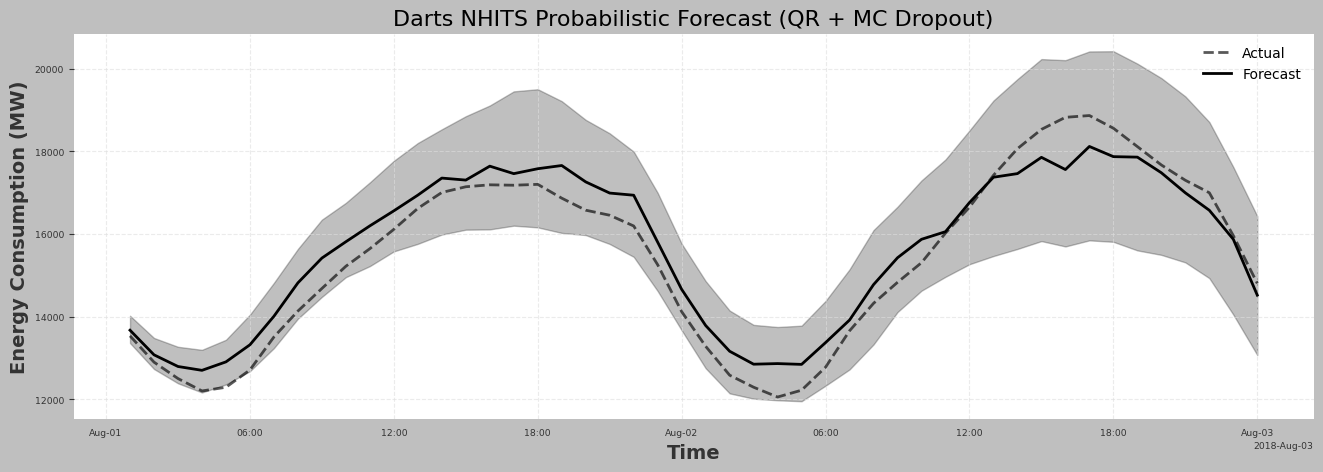

In [74]:
plot_darts_forecast(
    d_test, 
    nhits_forecast_qr_mc_inv, 
    'Darts NHITS Probabilistic Forecast (QR + MC Dropout)'
)

In [75]:
loss_p05 = mql(d_test, nhits_forecast_qr_mc_inv, q=0.05)
loss_p50 = mql(d_test, nhits_forecast_qr_mc_inv, q=0.50)
loss_p95 = mql(d_test, nhits_forecast_qr_mc_inv, q=0.95)

print(f"QuantileRegression with MC Average Quantile Loss at 5th percentile:  {loss_p05:.4f}")
print(f"QuantileRegression with MC Average Quantile Loss at 50th percentile (MAE): {loss_p50:.4f}")
print(f"QuantileRegression with MC Average Quantile Loss at 95th percentile: {loss_p95:.4f}")

QuantileRegression with MC Average Quantile Loss at 5th percentile:  103.8559
QuantileRegression with MC Average Quantile Loss at 50th percentile (MAE): 476.6062
QuantileRegression with MC Average Quantile Loss at 95th percentile: 164.4435


In [92]:
y_true_series = d_test
y_pred_p05_series = nhits_forecast_qr_mc_inv.quantile(0.05)
y_pred_p95_series = nhits_forecast_qr_mc_inv.quantile(0.95)

# Calculate the empirical coverage for the 90% interval
# pandas automatically aligns the series by their index
coverage_90 = ((y_true_series >= y_pred_p05_series) & (y_true_series <= y_pred_p95_series)).mean()
coverage_90

0.9791666666666666

## There's more

In [80]:
from darts.utils.likelihood_models import GaussianLikelihood

In [81]:
nhits_d_model_gauss = NHiTSModel(
    input_chunk_length=day*5, # 120 hours in 
    output_chunk_length=day*2, # 48 hours out 
    n_epochs=100, # modified
    num_blocks=1, 
    num_stacks=2, # modified (lowered)
    num_layers=1, # modified (lowered)
    pooling_kernel_sizes=None,
    n_freq_downsample=None, 
    batch_size=168, # modified (increased from 32)
    optimizer_kwargs={"lr": 0.001},
    model_name="AEP_hourly_gauss",
    random_state=42,
    force_reset=True,
    save_checkpoints=True,
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs,
    likelihood=GaussianLikelihood()
)

In [82]:
nhits_d_model_gauss.fit(
    series=d_train_scaled,
    val_series=d_val_scaled,
    verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 178 K  | train
-------------------------------------------------------------
117 K     Trainable params
61.6 K    Non-trainable params
178 K     Total params
0.716     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 719/719 [00:10<00:00, 69.44it/s, train_loss=0.504, val_loss=0.210]

Monitored metric val_loss did not improve in the last 11 records. Best score: 0.163. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 719/719 [00:10<00:00, 69.26it/s, train_loss=0.504, val_loss=0.210]


NHiTSModel(output_chunk_shift=0, num_stacks=2, num_blocks=1, num_layers=1, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=120, output_chunk_length=48, n_epochs=100, batch_size=168, optimizer_kwargs={'lr': 0.001}, model_name=AEP_hourly_gauss, random_state=42, force_reset=True, save_checkpoints=True, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'monitor': 'val_loss', 'factor': 0.2, 'patience': 3, 'min_lr': 1e-06, 'verbose': True}, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x35a1ff170>], 'enable_progress_bar': True, 'accelerator': 'auto'}, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, beta_nll=0.0, prior_strength=1.0))

In [83]:
d_train_val_sc = d_train_scaled.append(d_val_scaled)

nhits_forecast_gauss = nhits_d_model_gauss.predict(
    n=len(d_test),
    series=d_train_val_sc,
    num_samples=200
    )

nhits_forecast_gauss_inv = d_scaler.inverse_transform(nhits_forecast_gauss)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]


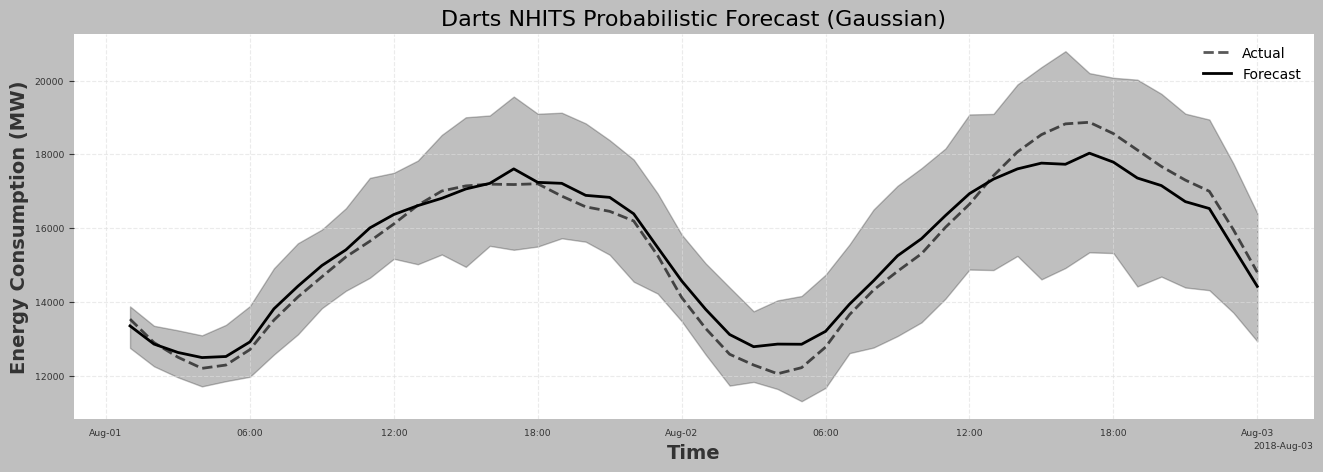

In [84]:
plot_darts_forecast(
    d_test, 
    nhits_forecast_gauss_inv, 
    'Darts NHITS Probabilistic Forecast (Gaussian)'
)

In [85]:
loss_p05 = mql(d_test, nhits_forecast_gauss_inv, q=0.05)
loss_p50 = mql(d_test, nhits_forecast_gauss_inv, q=0.50)
loss_p95 = mql(d_test, nhits_forecast_gauss_inv, q=0.95)

print(f"Gaussian Likelihood Average Quantile Loss at 5th percentile:  {loss_p05:.4f}")
print(f"Gaussian Likelihood Average Quantile Loss at 50th percentile (MAE): {loss_p50:.4f}")
print(f"Gaussian Likelihood Average Quantile Loss at 95th percentile: {loss_p95:.4f}")

Gaussian Likelihood Average Quantile Loss at 5th percentile:  160.8412
Gaussian Likelihood Average Quantile Loss at 50th percentile (MAE): 376.3907
Gaussian Likelihood Average Quantile Loss at 95th percentile: 168.2705


In [91]:
y_true_series = d_test
y_pred_p05_series = nhits_forecast_gauss_inv.quantile(0.05)
y_pred_p95_series = nhits_forecast_gauss_inv.quantile(0.95)

# Calculate the empirical coverage for the 90% interval
# pandas automatically aligns the series by their index
coverage_90 = ((y_true_series >= y_pred_p05_series) & (y_true_series <= y_pred_p95_series)).mean()
coverage_90

1.0

In [86]:
# Params for GaussianLikelihood 
forecast_params_gauss = nhits_d_model_gauss.predict(
    n=len(d_test),
    series=d_train_val_sc,
    predict_likelihood_parameters=True
)
print(forecast_params_gauss.to_dataframe().head())

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.43it/s]
                         y_mu   y_sigma
Datetime                               
2018-08-01 01:00:00 -0.805166  0.140893
2018-08-01 02:00:00 -1.027776  0.140102
2018-08-01 03:00:00 -1.109318  0.152793
2018-08-01 04:00:00 -1.173990  0.161144
2018-08-01 05:00:00 -1.124817  0.188276


In [87]:
print(forecast_params_gauss.to_dataframe().head())

                         y_mu   y_sigma
Datetime                               
2018-08-01 01:00:00 -0.805166  0.140893
2018-08-01 02:00:00 -1.027776  0.140102
2018-08-01 03:00:00 -1.109318  0.152793
2018-08-01 04:00:00 -1.173990  0.161144
2018-08-01 05:00:00 -1.124817  0.188276


In [88]:
# Params for QuantileRegression
forecast_params_qr = nhits_d_model_qr.predict(
    n=len(d_test),
    series=d_train_val_sc,
    predict_likelihood_parameters=True
)

print(forecast_params_qr.to_dataframe().head())

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.17it/s] 
                      y_q0.05   y_q0.50   y_q0.95
Datetime                                         
2018-08-01 01:00:00 -0.801715 -0.703966 -0.606822
2018-08-01 02:00:00 -1.037714 -0.919474 -0.807610
2018-08-01 03:00:00 -1.174309 -1.026826 -0.900245
2018-08-01 04:00:00 -1.234250 -1.069475 -0.898426
2018-08-01 05:00:00 -1.202631 -1.018375 -0.814162


# Probabilistic Forecasting NeuralForecast

In [94]:
# !uv pip install neuralforecast
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.models import  NHITS

2025-08-24 00:20:51,060	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-08-24 00:20:51,254	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [95]:
nf_df = df.reset_index().copy()
nf_df = nf_df.rename(columns={'Datetime': 'ds'})
nf_df['unique_id'] = 'AEP_hourly'
nf_df


,ds,y,unique_id
0,2004-10-01 01:00:00,12379.0,AEP_hourly
1,2004-10-01 02:00:00,11935.0,AEP_hourly
2,2004-10-01 03:00:00,11692.0,AEP_hourly
3,2004-10-01 04:00:00,11597.0,AEP_hourly
4,2004-10-01 05:00:00,11681.0,AEP_hourly
...,...,...,...
121291,2018-08-02 20:00:00,17673.0,AEP_hourly
121292,2018-08-02 21:00:00,17303.0,AEP_hourly
121293,2018-08-02 22:00:00,17001.0,AEP_hourly
121294,2018-08-02 23:00:00,15964.0,AEP_hourly


In [96]:
day = 24
week = day*7

n_test = day*2 
n_val = week*2

nf_train = nf_df.iloc[:-n_test]
nf_test = nf_df.iloc[-n_test:]

print(nf_train.shape)
print(nf_test.shape)

(121248, 3)
(48, 3)


In [97]:
levels = [80, 90, 95]

nhits = NHITS(
    input_size=day*5,
    h=day*2,
    loss=MQLoss(level=levels),
    valid_loss=MQLoss(level=levels)
)

Seed set to 1


In [98]:
nf_model = NeuralForecast(models=[nhits], freq='h')

In [99]:
nf_model.fit(df=nf_train, val_size=n_val)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 7      | train
1 | valid_loss   | MQLoss        | 7      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
3.0 M     Trainable params
14        Non-trainable params
3.0 M     Total params
11.899    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s, v_num=41, train_loss_step=951.0, train_loss_epoch=951.0, valid_loss=897.0]      

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 15.98it/s, v_num=41, train_loss_step=951.0, train_loss_epoch=951.0, valid_loss=897.0]


In [100]:
nf_forecast = nf_model.predict()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


In [101]:
nf_forecast.head()

,unique_id,ds,NHITS-median,NHITS-lo-95,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,NHITS-hi-95
0,AEP_hourly,2018-08-01 01:00:00,13571.436523,13286.341797,13362.982422,13447.630859,13576.256836,13660.316406,13743.527344
1,AEP_hourly,2018-08-01 02:00:00,13012.808594,12717.882812,12723.744141,12839.001953,13074.820312,13137.649414,13138.587891
2,AEP_hourly,2018-08-01 03:00:00,12575.950195,12315.018555,12446.865234,12591.596680,12847.338867,12867.916016,12894.746094
3,AEP_hourly,2018-08-01 04:00:00,12545.311523,12149.640625,12294.008789,12307.409180,12767.268555,12814.480469,12932.427734
4,AEP_hourly,2018-08-01 05:00:00,12700.180664,12204.166016,12243.882812,12330.201172,12998.188477,13048.413086,13134.798828


In [102]:
nf_forecast.columns

Index(['unique_id', 'ds', 'NHITS-median', 'NHITS-lo-95', 'NHITS-lo-90',
       'NHITS-lo-80', 'NHITS-hi-80', 'NHITS-hi-90', 'NHITS-hi-95'],
      dtype='object')

In [ ]:
import matplotlib.pyplot as plt

def nf_plot_forecast(forecast_df, actuals_df, point_forecast, title):
    """
    Plots NeuralForecast predictions against actuals with prediction intervals.

    Args:
        forecast_df (pd.DataFrame): DataFrame from `nf.predict()` containing forecasts.
        actuals_df (pd.DataFrame): DataFrame with the true values for the forecast horizon.
        point_forecast (str): The column name of the point forecast in `forecast_df`.
        title (str): The title for the plot.
    """
    df = forecast_df.copy()
    df = df.set_index('ds')

    # Extract forecast 
    nf_yhat = df[point_forecast]
    lower_95 = df['NHITS-lo-95']
    upper_95 = df['NHITS-hi-95']
    lower_80 = df['NHITS-lo-80']
    upper_80 = df['NHITS-hi-80']

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot Forecast 
    nf_yhat.plot(ax=ax, lw=2, label='Forecast')

    # Plot Actuals (test)
    actuals_df.set_index('ds')['y'].plot(ax=ax, style='--', lw=1.5, label='Actual')

    # Plot the 95% prediction interval
    ax.fill_between(
        df.index, 
        lower_95, 
        upper_95,
        alpha=0.15, # prediction band transparency
        label='95% PI'
    )
    # Plot the 80% prediction interval
    ax.fill_between(
        df.index, 
        lower_80, 
        upper_80,
        alpha=0.4, # prediction band transparency
        label='80% PI'
    )

    ax.set_title(title)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('MW')
    ax.legend()
    ax.grid(True, axis='y', alpha=0.2)
    plt.tight_layout()
    plt.show()


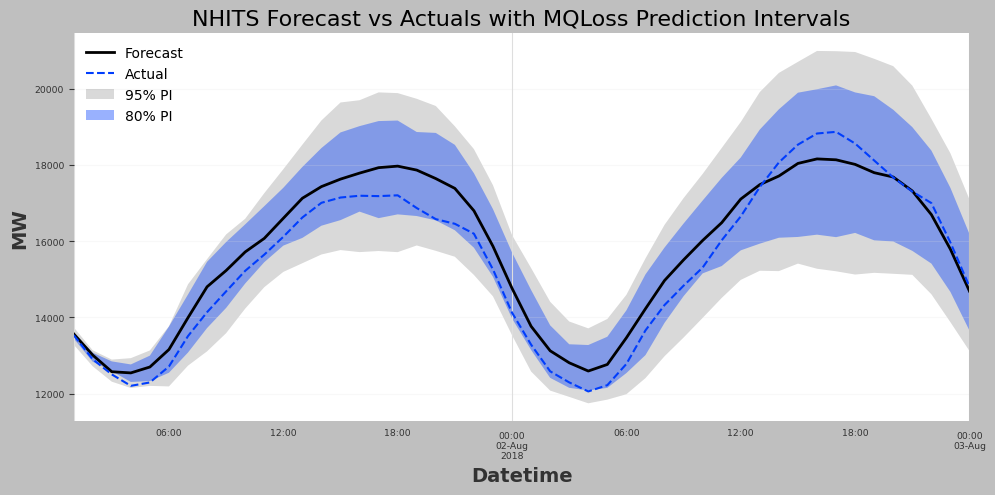

In [104]:
nf_plot_forecast(nf_forecast, 
                 actuals_df=nf_test,
                 point_forecast='NHITS-median', 
                 title='NHITS Forecast vs Actuals with MQLoss Prediction Intervals')

In [105]:
import numpy as np

# Define the quantile loss function
def quantile_loss(y_true, y_pred, q):
    """
    This implementation matches the Darts library, where the result is scaled by 2
    so that the loss for the median (q=0.5) is equivalent to the MAE
    """
    errors = y_true - y_pred
    losses = 2.0 * np.maximum((q - 1) * errors, q * errors)
    return np.mean(losses)

results_df = pd.merge(nf_test, nf_forecast, on='ds')

# Extract the actual values
y_true = results_df['y']

# Extract the predicted quantile values
y_pred_p05 = results_df['NHITS-lo-90']
y_pred_p50 = results_df['NHITS-median'] 
y_pred_p95 = results_df['NHITS-hi-90']

# Calculate the loss for each quantile
loss_p05 = quantile_loss(y_true, y_pred_p05, q=0.05)
loss_p50 = quantile_loss(y_true, y_pred_p50, q=0.50)
loss_p95 = quantile_loss(y_true, y_pred_p95, q=0.95)

print(f"NeuralForecast Average Quantile Loss with MQLoss at 5th percentile:  {loss_p05:.4f}")
print(f"NeuralForecast Average Quantile Loss with MQLoss at 50th percentile (MAE): {loss_p50:.4f}")
print(f"NeuralForecast Average Quantile Loss with MQLoss at 95th percentile: {loss_p95:.4f}")

NeuralForecast Average Quantile Loss with MQLoss at 5th percentile:  106.4772
NeuralForecast Average Quantile Loss with MQLoss at 50th percentile (MAE): 489.1147
NeuralForecast Average Quantile Loss with MQLoss at 95th percentile: 167.7960


In [106]:
coverage = ((y_true >= y_pred_p05) & (y_true <= y_pred_p95)).mean()
print(f"Empirical coverage: {coverage:.3f}")

Empirical coverage: 0.979


In [107]:
nf_forecast.columns

Index(['unique_id', 'ds', 'NHITS-median', 'NHITS-lo-95', 'NHITS-lo-90',
       'NHITS-lo-80', 'NHITS-hi-80', 'NHITS-hi-90', 'NHITS-hi-95'],
      dtype='object')

## There's more

In [108]:
from neuralforecast.utils import PredictionIntervals
from neuralforecast.losses.pytorch import MAE

In [109]:
?PredictionIntervals

Init signature:
PredictionIntervals(
    n_windows: int = 2,
    method: str = 'conformal_distribution',
)
Docstring:      Class for storing prediction intervals metadata information.
Init docstring:
n_windows : int
    Number of windows to evaluate.
method : str, default is conformal_distribution
    One of the supported methods for the computation of prediction intervals:
    conformal_error or conformal_distribution
File:           ~/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev2/lib/python3.12/site-packages/neuralforecast/utils.py
Type:           type
Subclasses:     

In [110]:
prediction_intervals = PredictionIntervals(method='conformal_distribution')

In [111]:
nhits_cp = NHITS(
    input_size=day*5,
    h=day*2,
    loss=MAE(),
    valid_loss=MAE()
)
nf_cp_model = NeuralForecast(models=[nhits_cp], freq='h')
nf_cp_model.fit(df=nf_train, val_size=n_val,  prediction_intervals=prediction_intervals)

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | valid_loss   | MAE           | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.864    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s, v_num=43, train_loss_step=706.0, train_loss_epoch=706.0]    

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 21.60it/s, v_num=43, train_loss_step=706.0, train_loss_epoch=706.0]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | valid_loss   | MAE           | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | blocks       | ModuleList    | 2.7 M  | train
-------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.864    Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode



Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s, v_num=45, train_loss_step=623.0, train_loss_epoch=623.0, valid_loss=602.0]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s, v_num=45, train_loss_step=623.0, train_loss_epoch=623.0, valid_loss=602.0]


In [112]:
nf_cp_forecast = nf_cp_model.predict(level=[80, 90, 95])
nf_cp_forecast.head()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


,unique_id,ds,NHITS,NHITS-lo-95,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,NHITS-hi-95
0,AEP_hourly,2018-08-01 01:00:00,13567.937500,13416.565820,13417.280078,13418.708594,13717.166406,13718.594922,13719.309180
1,AEP_hourly,2018-08-01 02:00:00,12963.250977,12732.088062,12737.492529,12748.301465,13178.200488,13189.009424,13194.413892
2,AEP_hourly,2018-08-01 03:00:00,12608.458984,12348.457324,12353.218359,12362.740430,12854.177539,12863.699609,12868.460645
3,AEP_hourly,2018-08-01 04:00:00,12415.100586,12146.922363,12153.407227,12166.376953,12663.824219,12676.793945,12683.278809
4,AEP_hourly,2018-08-01 05:00:00,12619.292969,12295.313574,12299.405469,12307.589258,12930.996680,12939.180469,12943.272363


In [113]:
nf_cp_forecast.columns

Index(['unique_id', 'ds', 'NHITS', 'NHITS-lo-95', 'NHITS-lo-90', 'NHITS-lo-80',
       'NHITS-hi-80', 'NHITS-hi-90', 'NHITS-hi-95'],
      dtype='object')

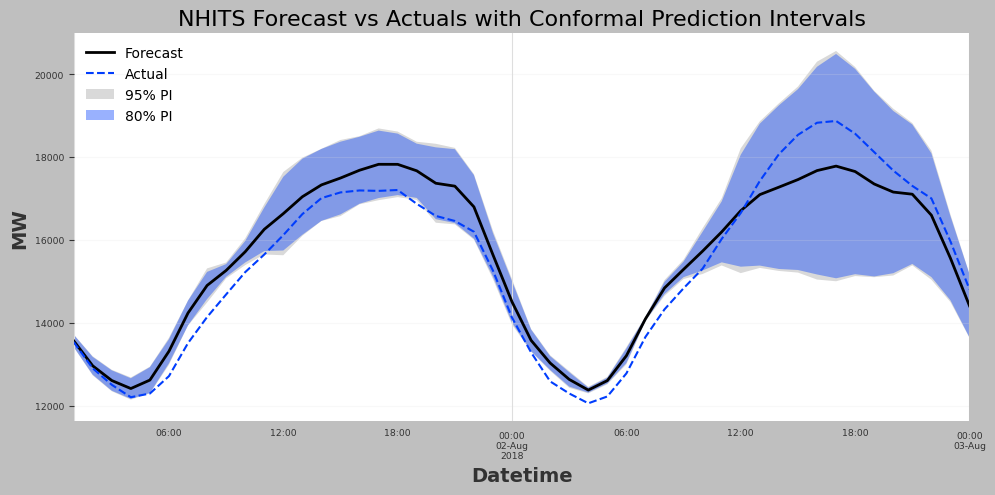

In [114]:
nf_plot_forecast(nf_cp_forecast, 
                 actuals_df=nf_test,
                 point_forecast='NHITS', 
                 title='NHITS Forecast vs Actuals with Conformal Prediction Intervals')

In [115]:
results_cp_df = pd.merge(nf_test, nf_cp_forecast, on='ds')

# Extract the predicted quantile values
y_pred_cp_p05 = results_cp_df['NHITS-lo-90']
y_pred_cp_p50 = results_cp_df['NHITS'] 
y_pred_cp_p95 = results_cp_df['NHITS-hi-90']

# Extract the actual values
y_true = results_df['y']

# Calculate the loss for each quantile
loss_cp_p05 = quantile_loss(y_true, y_pred_cp_p05, q=0.05)
loss_cp_p50 = quantile_loss(y_true, y_pred_cp_p50, q=0.50)
loss_cp_p95 = quantile_loss(y_true, y_pred_cp_p95, q=0.95)

print(f"NeuralForecast Average Quantile Loss with CP at 5th percentile:  {loss_cp_p05:.4f}")
print(f"NeuralForecast Average Quantile Loss with CP at 50th percentile (MAE): {loss_cp_p50:.4f}")
print(f"NeuralForecast Average Quantile Loss with CP at 95th percentile: {loss_cp_p95:.4f}")

NeuralForecast Average Quantile Loss with CP at 5th percentile:  235.2145
NeuralForecast Average Quantile Loss with CP at 50th percentile (MAE): 498.5925
NeuralForecast Average Quantile Loss with CP at 95th percentile: 101.9440


In [116]:
coverage = ((y_true >= y_pred_cp_p05) & (y_true <= y_pred_cp_p95)).mean()
print(f"Empirical coverage: {coverage:.3f}")

Empirical coverage: 0.646


# Probabilistic Forecasting with NeuralProphet

In [1]:
from neuralprophet import NeuralProphet, set_random_seed

set_random_seed(seed=42)

In [8]:
df_np = df.copy()
df_np.reset_index(inplace=True)
df_np.rename(columns={'Datetime': 'ds'}, inplace=True)

In [9]:
day = 24
week = day*7

n_total = len(df_np)
n_test = day*2 
n_val = week*2

# Calculate split indices
test_start = n_total - n_test
val_start = test_start - n_val
        
# Create splits maintaining temporal order
train_np = df_np[:val_start]
val_np= df_np[val_start:test_start]
test_np = df_np[test_start:]

print(f"""
train_np : {len(train_np)}
val_np : {len(val_np)}
test_np: {len(test_np)}
""")


train_np : 120912
val_np : 336
test_np: 48



In [10]:
quantile_list = [0.05, 0.95]

In [11]:
m = NeuralProphet(quantiles=quantile_list)
m.set_plotting_backend("plotly-static")
metrics = m.fit(train_np, validation_df=val_np, freq="H", progress=False)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future ve

Finding best initial lr:   0%|          | 0/277 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 80. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



In [12]:
forecast = m.predict(test_np)

WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 97.917% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/df_utils.py:1173: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aux_ts = pd.DataFrame(pd.date_range("1994-01-01", periods=100, freq=freq_str))

WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Se

In [13]:
forecast.columns

Index(['ds', 'y', 'yhat1', 'yhat1 5.0%', 'yhat1 95.0%', 'trend',
       'season_yearly', 'season_weekly', 'season_daily'],
      dtype='object')

WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



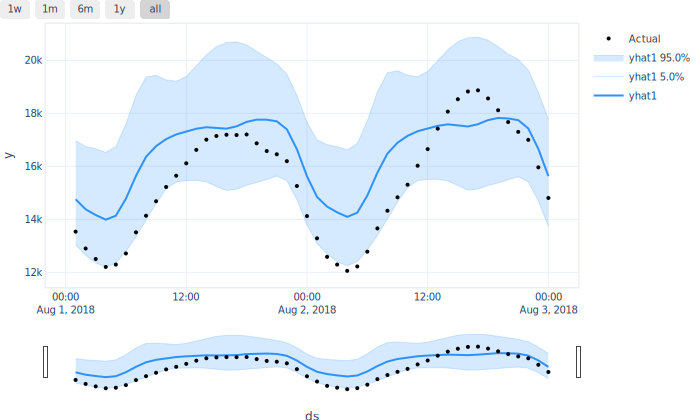

In [14]:
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




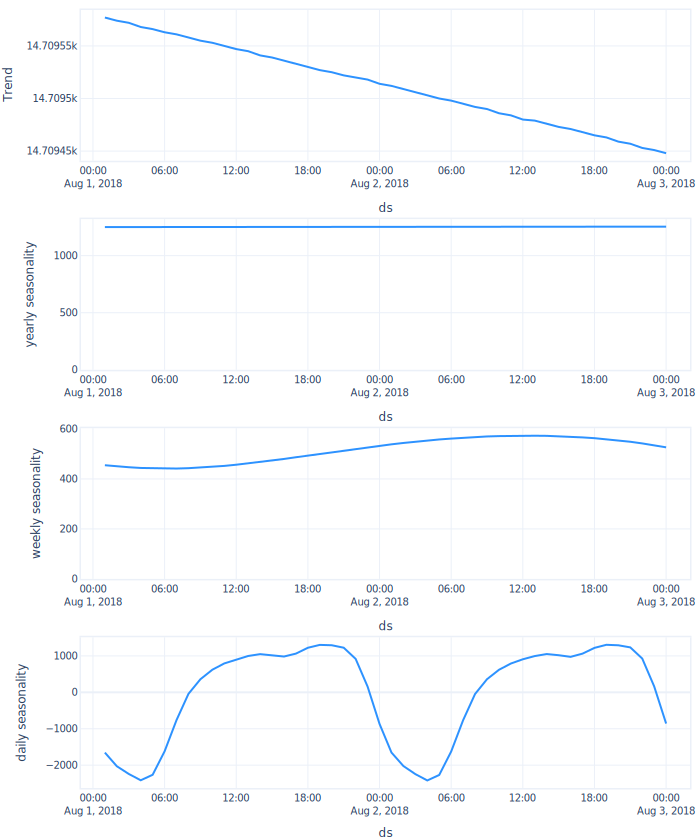

In [15]:
m.plot_components(forecast)

In [16]:
forecast.shape

(48, 9)

In [17]:
forecast.columns

Index(['ds', 'y', 'yhat1', 'yhat1 5.0%', 'yhat1 95.0%', 'trend',
       'season_yearly', 'season_weekly', 'season_daily'],
      dtype='object')

In [18]:
def quantile_loss(y_true, y_pred, q):
    """
    This implementation matches the Darts library, where the result is scaled by 2
    so that the loss for the median (q=0.5) is equivalent to the MAE
    """
    errors = y_true - y_pred
    losses = 2.0 * np.maximum((q - 1) * errors, q * errors)
    return np.mean(losses)


# Extract the predicted quantile values
y_pred_qr_p05 = forecast['yhat1 5.0%']
y_pred_qr_p50 = forecast['yhat1'] 
y_pred_qr_p95 = forecast['yhat1 95.0%']

# Extract the actual values
y_true = forecast['y']

# Calculate the loss for each quantile
loss_qr_p05 = quantile_loss(y_true, y_pred_qr_p05, q=0.05)
loss_qr_p50 = quantile_loss(y_true, y_pred_qr_p50, q=0.50)
loss_qr_p95 = quantile_loss(y_true, y_pred_qr_p95, q=0.95)

print(f"NeuralProphet Average Quantile Loss with QR at 5th percentile:  {loss_qr_p05:.4f}")
print(f"NeuralProphet Average Quantile Loss with QR at 50th percentile (MAE): {loss_qr_p50:.4f}")
print(f"NeuralProphet Average Quantile Loss with QR at 95th percentile: {loss_qr_p95:.4f}")

NeuralProphet Average Quantile Loss with QR at 5th percentile:  135.3577
NeuralProphet Average Quantile Loss with QR at 50th percentile (MAE): 1265.6756
NeuralProphet Average Quantile Loss with QR at 95th percentile: 361.3481


In [19]:
coverage_90_qr = ((y_true >= y_pred_qr_p05) & (y_true <= y_pred_qr_p95)).mean()
print(f"Neural Prophet QR Empirical Coverage (90%): {coverage_90_qr:.3f}")

Neural Prophet QR Empirical Coverage (90%): 0.854


## There's more

In [25]:
day = 24
week = day*7

n_total = len(df_np)

# Define sizes for each set
n_test = day * 2      # 2 days for final testing
n_calib =  week * 3     # 1 week for calibration
n_val = week * 2       # 1 week for validation
n_train = n_total - n_test - n_calib - n_val

# Create the splits chronologically
train_df = df_np[:n_train]
val_df = df_np[n_train : n_train + n_val]
calib_df = df_np[n_train + n_val : n_train + n_val + n_calib]
test_df = df_np[n_train + n_val + n_calib:]

print(f"""
train_df : {len(train_df)}
val_df : {len(val_df)}
test_df: {len(test_df)}
calib_df {len(calib_df)}
""")


train_df : 120408
val_df : 336
test_df: 48
calib_df 504



In [26]:
method = "cqr"

cqr_forecast = m.conformal_predict(
    test_np, 
    calibration_df=calib_df, 
    alpha=0.10, 
    method=method, 
    plotting_backend="plotly-static"
)

WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.802% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/df_utils.py:1173: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.


WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a fu

WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




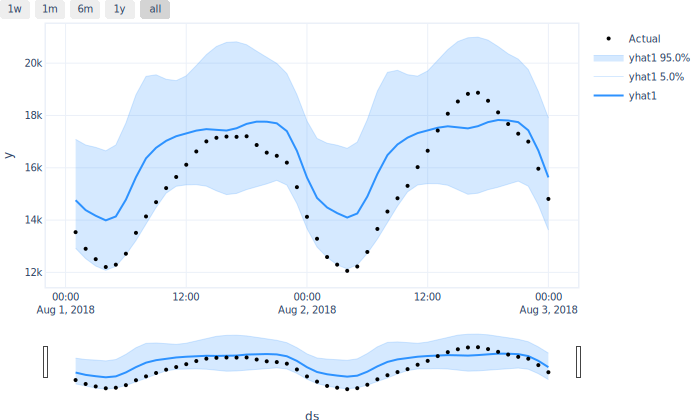

In [27]:
m.plot(cqr_forecast)

In [28]:
# Extract the predicted quantile values
y_pred_cp_p05 = cqr_forecast['yhat1 5.0%']
y_pred_cp_p50 = cqr_forecast['yhat1'] 
y_pred_cp_p95 = cqr_forecast['yhat1 95.0%']

# Extract the actual values
y_true = cqr_forecast['y']

# Calculate the loss for each quantile
loss_cp_p05 = quantile_loss(y_true, y_pred_cp_p05, q=0.05)
loss_cp_p50 = quantile_loss(y_true, y_pred_cp_p50, q=0.50)
loss_cp_p95 = quantile_loss(y_true, y_pred_cp_p95, q=0.95)

print(f"NeuralProphet Average Quantile Loss with CQR at 5th percentile:  {loss_cp_p05:.4f}")
print(f"NeuralProphet Average Quantile Loss with CQR at 50th percentile (MAE): {loss_cp_p50:.4f}")
print(f"NeuralProphet Average Quantile Loss with CQR at 95th percentile: {loss_cp_p95:.4f}")

NeuralProphet Average Quantile Loss with CQR at 5th percentile:  119.7666
NeuralProphet Average Quantile Loss with CQR at 50th percentile (MAE): 1265.6756
NeuralProphet Average Quantile Loss with CQR at 95th percentile: 373.2079


In [29]:
coverage_90_cqr = ((y_true >= y_pred_cp_p05) & (y_true <= y_pred_cp_p95)).mean()
print(f"Neural Prophet CQR Empirical Coverage (90%): {coverage_90_cqr:.3f}")

Neural Prophet CQR Empirical Coverage (90%): 0.958


In [26]:
coverage = ((y_true >= y_pred_cp_p05) & (y_true <= y_pred_cp_p95)).mean()
print(f"Empirical coverage: {coverage:.3f}")

Empirical coverage: 0.833


## Even More


train_np : 120576
val_np : 336
test_np: 48
calibration 336



In [153]:
m = NeuralProphet(quantiles=quantile_list)
m.set_plotting_backend("plotly-static")
metrics = m.fit(train_df, validation_df=val_df, freq="H", progress=False)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO 

Finding best initial lr:   0%|          | 0/277 [00:00<?, ?it/s]

In [154]:
method = "cqr"

cqr_forecast = m.conformal_predict(
    test_df, 
    calibration_df=calib_df, 
    alpha=0.10, 
    method=method, 
    plotting_backend="plotly-static"
)

WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


INFO - (NP.df_utils._infer_frequency) - Major frequency h corresponds to 99.702% of the data.
WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/df_utils.py:1173: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.


WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a fu

WARNING - (py.warnings._showwarnmsg) - /Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/dev3/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




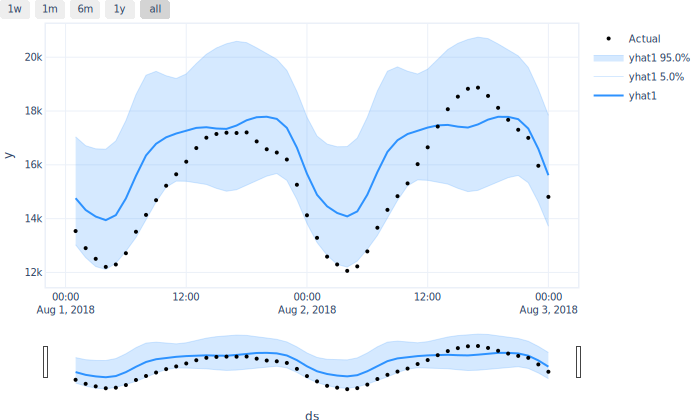

In [155]:
m.plot(cqr_forecast)

In [156]:
# Extract the predicted quantile values
y_pred_cp_p05 = cqr_forecast['yhat1 5.0%']
y_pred_cp_p50 = cqr_forecast['yhat1'] 
y_pred_cp_p95 = cqr_forecast['yhat1 95.0%']

# Extract the actual values
y_true = cqr_forecast['y']

# Calculate the loss for each quantile
loss_cp_p05 = quantile_loss(y_true, y_pred_cp_p05, q=0.05)
loss_cp_p50 = quantile_loss(y_true, y_pred_cp_p50, q=0.50)
loss_cp_p95 = quantile_loss(y_true, y_pred_cp_p95, q=0.95)

print(f"NeuralProphet Average Quantile Loss with CQR at 5th percentile:  {loss_cp_p05:.4f}")
print(f"NeuralProphet Average Quantile Loss with CQR at 50th percentile (MAE): {loss_cp_p50:.4f}")
print(f"NeuralProphet Average Quantile Loss with CQR at 95th percentile: {loss_cp_p95:.4f}")

NeuralProphet Average Quantile Loss with CQR at 5th percentile:  130.9835
NeuralProphet Average Quantile Loss with CQR at 50th percentile (MAE): 1251.9841
NeuralProphet Average Quantile Loss with CQR at 95th percentile: 359.7467


In [157]:
coverage_90_cqr = ((y_true >= y_pred_cp_p05) & (y_true <= y_pred_cp_p95)).mean()
print(f"Neural Prophet CQR Empirical Coverage (90%): {coverage_90_cqr:.3f}")

Neural Prophet CQR Empirical Coverage (90%): 0.854


# Using MAPIE

In [53]:
!uv pip install -q mapie scikit-learn

In [51]:
import mapie
print(mapie.__version__)


1.0.1


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from mapie.regression.time_series_regression import TimeSeriesRegressor

In [53]:
# Recreate splits for this recipe
train_df = df.iloc[:-48]
test_df = df.iloc[-48:]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Train size: 121248
Test size: 48


In [59]:
def create_features(df):
    """Creates time and lag features from a dataframe."""
    df_feat = df.copy()
    df_feat['hour'] = df_feat.index.hour
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month

    # Create lagged features for the last 2 days
    for i in range(1, 6):
        df_feat[f'lag_{i}'] = df_feat['y'].shift(i)

    return df_feat.dropna()

# Create features for the entire dataset
df_features = create_features(df)

# Split features and target into train and test sets
X = df_features.drop('y', axis=1)
y = df_features['y']

X_train, y_train = X.iloc[:-48], y.iloc[:-48]
X_test, y_test = X.iloc[-48:], y.iloc[-48:]

In [60]:
df_features.columns

Index(['y', 'hour', 'dayofweek', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5'],
      dtype='object')

In [61]:
# A RandomForestRegressor is a good choice for this type of feature set
estimator = RandomForestRegressor(random_state=42, n_jobs=-1)

# Wrap the estimator with MAPIE's TimeSeriesRegressor
mapie = TimeSeriesRegressor(
    estimator,
    method="enbpi",
    n_jobs=-1
)

In [62]:
print("Fitting the EnbPI model...")
mapie.fit(X_train, y_train)

Fitting the EnbPI model...


,estimator,RandomForestR...ndom_state=42)
,method,'enbpi'
,cv,None
,n_jobs,-1
,agg_function,'mean'
,verbose,0
,conformity_score,None
,random_state,None
,n_estimators,100
,criterion,'squared_error'
,max_depth,None


In [63]:
alpha = 0.10 # Corresponds to a 90% prediction interval
y_pred_online = []
y_pis_online = []

print("Performing online forecasting...")
for i in range(len(X_test)):
    # Predict the next single data point
    X_step = X_test.iloc[[i]]
    y_pred, y_pis = mapie.predict(X_step, confidence_level=1-alpha)

    # Store the results
    y_pred_online.append(y_pred[0])
    y_pis_online.append(y_pis[0])

    # Update the model with the actual value for this step
    y_step = y_test.iloc[[i]]
    mapie.partial_fit(X_step, y_step)

# Convert lists to numpy arrays for easier plotting
y_pred_online = np.array(y_pred_online)
y_pis_online = np.array(y_pis_online)

Performing online forecasting...


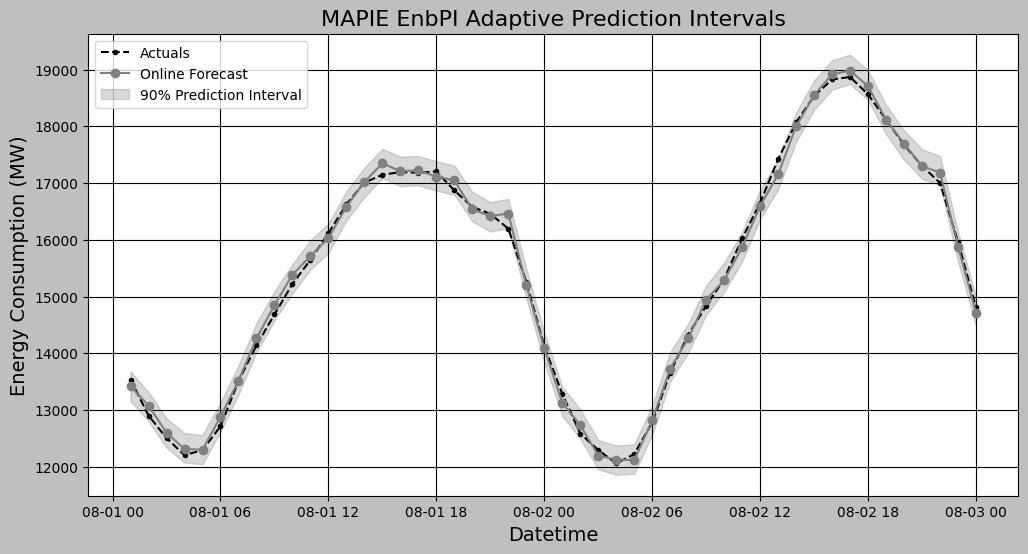

In [67]:
lower_bounds = y_pis_online[:, 0, 0]
upper_bounds = y_pis_online[:, 1, 0]

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, color='black', marker='.', linestyle='--', label='Actuals')
plt.plot(y_test.index, y_pred_online, color='gray', marker='o', linestyle='-', label='Online Forecast')
plt.fill_between(
    y_test.index,
    lower_bounds,
    upper_bounds,
    color='gray',
    alpha=0.3,
    label='90% Prediction Interval'
)
plt.title("MAPIE EnbPI Adaptive Prediction Intervals")
plt.xlabel("Datetime")
plt.ylabel("Energy Consumption (MW)")
plt.legend()
plt.grid(True)
plt.show()

In [65]:
coverage = ((y_test >= lower_bounds) & (y_test <= upper_bounds)).mean()
print(f"Empirical coverage: {coverage:.3f}")

Empirical coverage: 0.958
